![Gan1](../img/gan/gan1.png)
![Gan2](../img/gan/gan2.png)
![Gan3](../img/gan/gan3.png)

In [16]:
#The discriminative network is constantly trying to find differences between the fake images and real images
#and the generative network keeps getting closer and closer to the real deal.
#In the end, we've trained the generative network to produce images that can't be differentiated from real images.

from __future__ import division, print_function, absolute_import

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Import MNIST data

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('../mnist', one_hot=True)

from keras import backend as K
#Clear TF memory
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

Extracting ../mnist\train-images-idx3-ubyte.gz
Extracting ../mnist\train-labels-idx1-ubyte.gz
Extracting ../mnist\t10k-images-idx3-ubyte.gz
Extracting ../mnist\t10k-labels-idx1-ubyte.gz


In [13]:
#Training Params
num_steps = 50000
batch_size = 128
learning_rate = 0.0002

#Network Params
image_dim = 784 #28*28 pixels
gen_hidden_dim = 256
disc_hidden_dim = 256
noise_dim = 100 #Noise data point

#A custom initialization(Xavier Glorot init)
def glorot_init(shape):
    return tf.random_normal(shape=shape, stddev=1.0/tf.sqrt(shape[0]/2.0))

In [3]:
#Weights and Biases
weights = {
    'gen_hidden1': tf.Variable(glorot_init([noise_dim, gen_hidden_dim])),
    'gen_out': tf.Variable(glorot_init([gen_hidden_dim, image_dim])),
    'disc_hidden1': tf.Variable(glorot_init([image_dim, disc_hidden_dim])),
    'disc_out': tf.Variable(glorot_init([disc_hidden_dim, 1]))
}

biases = {
    'gen_hidden1': tf.Variable(tf.zeros([gen_hidden_dim])),
    'gen_out': tf.Variable(tf.zeros([image_dim])),
    'disc_hidden1': tf.Variable(glorot_init([disc_hidden_dim])),
    'disc_out': tf.Variable(glorot_init([1]))
}

In [4]:
#Generator
def generator(x):
    hidden_layer = tf.matmul(x, weights['gen_hidden1'])
    hidden_layer = tf.add(hidden_layer, biases['gen_hidden1'])
    hidden_layer = tf.nn.relu(hidden_layer)
    
    out_layer = tf.matmul(hidden_layer, weights['gen_out'])
    out_layer = tf.add(out_layer, biases['gen_out'])
    out_layer = tf.nn.sigmoid(out_layer)
    
    return out_layer
    
def discriminator(x):
    hidden_layer = tf.matmul(x, weights['disc_hidden1'])
    hidden_layer = tf.add(hidden_layer, biases['disc_hidden1'])
    hidden_layer = tf.nn.relu(hidden_layer)
    
    out_layer = tf.matmul(hidden_layer, weights['disc_out'])
    out_layer = tf.add(out_layer, biases['disc_out'])
    out_layer = tf.nn.sigmoid(out_layer)
    
    return out_layer

In [5]:
#Build Networks
#Network inputs
gen_input = tf.placeholder(dtype=tf.float32, shape=[None, noise_dim], name='input_noise')
disc_input = tf.placeholder(dtype=tf.float32, shape=[None, image_dim], name='disc_input')

#Buid Generator Network
gen_sample = generator(gen_input)

#Build 2 Discriminator Networks(one from noise input, one from generated samples)
disc_real = discriminator(disc_input) #noise input
disc_fake = discriminator(gen_sample) #generated samples

#Build loss
gen_loss = -tf.reduce_mean(tf.log(disc_fake))
disc_loss = -tf.reduce_mean(tf.log(disc_real) + tf.log(1.0 - disc_fake))

#Build optimizers
optimizer_gen = tf.train.AdamOptimizer(learning_rate=learning_rate)
optimizer_disc = tf.train.AdamOptimizer(learning_rate=learning_rate)

#Train Variables for each optimizer
#By default in TF, all variables are updated by each optimizer,
#so we need to precise for each one of them the specific variables to update.
#Generator Network variables
gen_vars = [weights['gen_hidden1'], weights['gen_out'],
           biases['gen_hidden1'], biases['gen_out']]

#Discriminator Network variables
disc_vars = [weights['disc_hidden1'], weights['disc_hidden1'],
            biases['disc_out'], biases['disc_out']]

#Create training operations
train_gen = optimizer_gen.minimize(gen_loss, var_list=gen_vars)
train_disc = optimizer_disc.minimize(disc_loss, var_list=disc_vars)

#Init global var
init = tf.global_variables_initializer()

In [14]:
#Start training
#Start a new TF session
sess = tf.Session()

#Run the init
sess.run(init)

#Training
for i in range(1, num_steps+1):
    #Prepare data
    #Get the next batch of Mnist data (only images needed, not labels)
    batch_x, _ = mnist.train.next_batch(batch_size)
    
    #Generate noise to feed the generator
    z = np.random.uniform(-1.0, 1.0, size=[batch_size, noise_dim])
    
    #Train
    feed_dict = {disc_input: batch_x, gen_input: z}
    _, _, gl, dl = sess.run([train_gen, train_disc, gen_loss, disc_loss], feed_dict=feed_dict)
    
    if i % 1000 == 0 or i == 1:
        print('Step %i: Generator Loss: %f, Discriminator Loss: %f' % (i, gl, dl))

Step 1: Generator Loss: 1.532147, Discriminator Loss: 1.468984
Step 1000: Generator Loss: 3.253309, Discriminator Loss: 0.141811
Step 2000: Generator Loss: 3.316170, Discriminator Loss: 0.128774
Step 3000: Generator Loss: 2.534006, Discriminator Loss: 0.220764
Step 4000: Generator Loss: 2.478100, Discriminator Loss: 0.262875
Step 5000: Generator Loss: 2.255870, Discriminator Loss: 0.494864
Step 6000: Generator Loss: 2.386976, Discriminator Loss: 0.404172
Step 7000: Generator Loss: 2.141414, Discriminator Loss: 0.362136
Step 8000: Generator Loss: 2.676975, Discriminator Loss: 0.275809
Step 9000: Generator Loss: 2.139184, Discriminator Loss: 0.311576
Step 10000: Generator Loss: 2.139009, Discriminator Loss: 0.350326
Step 11000: Generator Loss: 2.330148, Discriminator Loss: 0.272238
Step 12000: Generator Loss: 2.568748, Discriminator Loss: 0.235222
Step 13000: Generator Loss: 2.867248, Discriminator Loss: 0.268626
Step 14000: Generator Loss: 2.481745, Discriminator Loss: 0.343774
Step 150

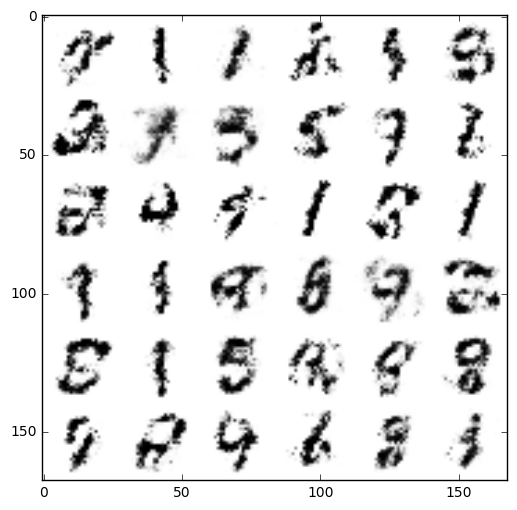

In [15]:
#Testing
#Generate images from noise, using the generator network
n = 6
canvas = np.empty((28*n, 28*n))

for i in range(n):
    #Noise input
    z = np.random.uniform(-1.0, 1.0, size=[n, noise_dim])
    #generate image from noise
    g = sess.run(gen_sample, feed_dict={gen_input: z})
    #Reverse colors for better display
    g = -1 * (g-1)
    for j in range(n):
        #Draw the generated digits
        canvas[i*28:(i+1)*28, j*28:(j+1)*28] = g[j].reshape([28, 28])
        
plt.figure(figsize=(n, n))
plt.imshow(canvas, origin='upper', cmap='gray')
plt.show()